# Link Prediction

GPU acceleration dengan CUDA

In [8]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [9]:
!pip install igraph

In [10]:
!pip install networkit

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import pickle
import random
import igraph as ig
import networkit as nk

from itertools import combinations
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Dataset Preparation

In [12]:
pickle_file_path = 'dataset/amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'rb') as f:
    G = pickle.load(f)

print(G)

DiGraph with 259102 nodes and 1207337 edges


### Features

#### Node Features

In [13]:

print(f"Total Nodes: {G.number_of_nodes()}")


for node, data in list(G.nodes(data=True))[:5]:
    print(f"Node: {node}, Data: {data}")

print()
sample_node = next(iter(G.nodes(data=True)))[1]
print("Node features:", list(sample_node.keys()))

Total Nodes: 259102
Node: 1, Data: {'title': 'Patterns of Preaching: A Sermon Sampler', 'group': 'Book', 'salesrank': 396585.0, 'review_cnt': 2, 'downloads': 2, 'rating': 5.0, 'in_degree': 0, 'out_degree': 4, 'pagerank_centrality': 6.210153588242165e-07, 'betweenness_centrality': 0.0, 'harmonic_closeness_centrality': 0.1442557706580312, 'degree_centrality': 1.5437995221940477e-05, 'community': 10}
Node: 2, Data: {'title': 'Candlemas: Feast of Flames', 'group': 'Book', 'salesrank': 168596.0, 'review_cnt': 12, 'downloads': 12, 'rating': 4.5, 'in_degree': 1, 'out_degree': 4, 'pagerank_centrality': 7.560926314778459e-07, 'betweenness_centrality': 31563.672353370643, 'harmonic_closeness_centrality': 0.1444868764333364, 'degree_centrality': 1.92974940274256e-05, 'community': 10}
Node: 4, Data: {'title': 'Life Application Bible Commentary: 1 and 2 Timothy and Titus', 'group': 'Book', 'salesrank': 631289.0, 'review_cnt': 1, 'downloads': 1, 'rating': 4.0, 'in_degree': 24, 'out_degree': 5, 'page

Fitur-fitur dari node dalam graph ini meliputi:  

*   **`title`**:  
    *   **Tipe Data**: String (Teks)  
    *   **Deskripsi**: Nama atau judul produk. Fitur ini memberikan deskripsi tekstual tentang produk yang dimaksud.  
    *   **Contoh**: "Patterns of Preaching: A Sermon Sampler", "Candlemas: Feast of Flames", dll.  

*   **`group`**:  
    *   **Tipe Data**: String (Kategorikal)  
    *   **Deskripsi**: Kategori atau grup tempat produk tersebut berada. Fitur ini membantu dalam memahami jenis produk (misalnya, Buku, Musik, DVD, dll.).  
    *   **Contoh**: "Book"  

*   **`salesrank`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Peringkat penjualan produk di Amazon. Semakin rendah nilai `salesrank`, semakin tinggi tingkat penjualan dan popularitasnya. Fitur ini sering digunakan untuk mengukur seberapa baik suatu produk terjual di Amazon.  
    *   **Contoh**: `396585.0`, `168596.0`, `1270652.0`, dll.  

*   **`review_cnt`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah ulasan pelanggan yang diterima oleh produk. Nilai `review_cnt` yang lebih tinggi bisa menunjukkan tingkat visibilitas produk yang lebih besar, popularitas yang lebih tinggi, atau keterlibatan pelanggan yang lebih banyak.  
    *   **Contoh**: `2`, `12`, `1`, `1`, `0`, dll.  

*   **`downloads`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah unduhan yang terkait dengan produk. Makna pastinya dapat bervariasi tergantung pada sumber dataset. Bisa saja mewakili unduhan produk digital atau metrik keterlibatan lainnya. Dalam konteks produk "Book" pada contoh ini, bisa merujuk pada unduhan sampel buku atau bentuk keterlibatan lain yang relevan dengan dataset.  
    *   **Contoh**: `2`, `12`, `1`, `1`, `0`, dll.  

*   **`rating`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Rata-rata rating pelanggan terhadap produk, biasanya dalam skala 0 hingga 5 (atau sistem serupa). Fitur ini mencerminkan tingkat kepuasan pelanggan serta persepsi kualitas produk secara keseluruhan.  
    *   **Contoh**: `5.0`, `4.5`, `5.0`, `4.0`, `0.0`, dll.   

*   **`in_degree`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah edge (sisi) yang masuk ke node ini. Menunjukkan seberapa banyak produk lain yang terhubung ke produk ini dalam graph. Dalam konteks dataset ini, bisa menunjukkan seberapa sering produk ini direferensikan oleh produk lain.  
    *   **Contoh**: `0`, `1`, `24`, `53`, `21`, dll.  

*   **`out_degree`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah edge (sisi) yang keluar dari node ini. Menunjukkan seberapa banyak produk lain yang direferensikan oleh produk ini.  
    *   **Contoh**: `4`, `4`, `5`, `5`, `5`, dll.  

*   **`pagerank_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Skor PageRank node dalam graph. Metrik ini mengukur kepentingan sebuah node berdasarkan jumlah dan kualitas tautan yang mengarah ke node tersebut. Semakin tinggi nilainya, semakin berpengaruh node tersebut dalam jaringan.  
    *   **Contoh**: `6.21e-07`, `7.56e-07`, `1.34e-05`, dll.  

*   **`betweenness_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Mengukur seberapa sering sebuah node menjadi perantara dalam jalur terpendek antara dua node lainnya. Node dengan betweenness centrality tinggi berperan sebagai "jembatan" yang menghubungkan berbagai bagian dalam graph.  
    *   **Contoh**: `0.0`, `31563.67`, `6528478.27`, `15442396.47`, dll.  

*   **`harmonic_closeness_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Versi alternatif dari closeness centrality yang menghitung seberapa dekat suatu node dengan node lain berdasarkan jarak harmonik. Makin tinggi nilainya, makin dekat node tersebut ke banyak node lain dalam graph.  
    *   **Contoh**: `0.1442`, `0.1444`, `0.1558`, `0.1658`, dll.  

*   **`degree_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Mengukur proporsi node lain yang terhubung dengan node ini dalam graph. Degree centrality dihitung sebagai jumlah total koneksi (degree) node ini dibagi dengan jumlah maksimum koneksi yang mungkin dalam graph.  
    *   **Contoh**: `1.54e-05`, `1.92e-05`, `1.11e-04`, `2.23e-04`, dll.  

*   **`community`**:  
    *   **Tipe Data**: Integer (Kategorikal)  
    *   **Deskripsi**: Identitas komunitas tempat node ini tergabung, berdasarkan algoritma deteksi komunitas. Node dalam komunitas yang sama lebih cenderung saling terhubung dibandingkan dengan node di komunitas lain.  
    *   **Contoh**: `10`, `10`, `10`, `31`, dll.  

#### Edge Features

In [14]:
print(f"Total Edges: {G.number_of_edges()}")

for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Edge: ({u}, {v}), Data: {data}")

sample_edge = next(iter(G.edges(data=True)))[2]
print("\nEdge features:", list(sample_edge.keys()))


Total Edges: 1207337
Edge: (1, 2), Data: {}
Edge: (1, 4), Data: {}
Edge: (1, 5), Data: {}
Edge: (1, 15), Data: {}
Edge: (2, 11), Data: {}

Edge features: []


Tidak ada edge feature pada graph ini

### Split Dataset

In [15]:
nkG = nk.nxadapter.nx2nk(G)

edges = list(G.edges())
existing_edges = set(edges)

# Sampling dengan Networkit Graph (lebih cepat)
def sample_non_edges_nk(nkG, num_samples):
    non_edges = set()
    nodes = list(G.nodes())

    while len(non_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if not nkG.hasEdge(u, v):  
            non_edges.add((u, v))

    return list(non_edges)

num_samples = len(edges) 
non_edges = sample_non_edges_nk(nkG, num_samples)

train_edges, test_edges = train_test_split(edges, test_size=0.2, random_state=42)
train_non_edges = random.sample(non_edges, len(train_edges)) 
test_non_edges = random.sample(non_edges, len(test_edges)) 

G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(train_edges)

print(f"Train Edges: {len(train_edges)}, Test Edges: {len(test_edges)}")
print(f"Train Non-Edges: {len(train_non_edges)}, Test Non-Edges: {len(test_non_edges)}")

Train Edges: 965869, Test Edges: 241468
Train Non-Edges: 965869, Test Non-Edges: 241468


## Heuristic Link Prediction

In [16]:
def heuristic_score(G, node_pairs, method):
    scores = []
    for u, v in tqdm(node_pairs, desc=f"Computing {method} scores", disable=True):
        if method == "common_neighbors":
            score = len(list(nx.common_neighbors(G, u, v)))
        elif method == "jaccard":
            score = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        elif method == "adamic_adar":
            score = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        elif method == "preferential_attachment":
            score = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        else:
            raise ValueError("Method not recognized")
        scores.append(score)
    return scores


In [28]:
# Metrik evaluasi ranking problem
def precision_at_k(y_true, y_scores, k):
    sorted_indices = np.argsort(y_scores)[::-1] 
    top_k = sorted_indices[:k]
    return np.mean(y_true[top_k])

def recall_at_k(y_true, y_scores, k):
    sorted_indices = np.argsort(y_scores)[::-1]
    top_k = sorted_indices[:k]
    return np.sum(y_true[top_k]) / np.sum(y_true)

def mean_average_precision(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)[::-1]
    relevant = np.cumsum(y_true[sorted_indices])
    precision_at_i = relevant / (np.arange(len(y_true)) + 1)
    return np.sum(precision_at_i * y_true[sorted_indices]) / np.sum(y_true)

def f1_beta_at_k(y_true, y_scores, k, beta=1):
    precision_k = precision_at_k(y_true, y_scores, k)
    recall_k = recall_at_k(y_true, y_scores, k)
    
    if precision_k + recall_k == 0:
        return 0.0
    
    beta_sq = beta ** 2
    return (1 + beta_sq) * (precision_k * recall_k) / ((beta_sq * precision_k) + recall_k)



In [29]:
test_pairs = test_edges + test_non_edges
labels = np.array([1] * len(test_edges) + [0] * len(test_non_edges))

methods = ["common_neighbors", "jaccard", "adamic_adar", "preferential_attachment"]
k = 100000

print("{:<25} {:>10} {:>10} {:>15} {:>15} {:>10} {:>10}".format(
    "Method", "AUC-ROC", "AP Score", f"Precision@{k}", f"Recall@{k}", "MAP", f"F1@{k}"
))
print("=" * 105)

results = []
for method in methods:
    scores = np.array(heuristic_score(G_train, test_pairs, method))

    auc_roc = roc_auc_score(labels, scores)
    ap_score = average_precision_score(labels, scores)

    p_at_k = precision_at_k(labels, scores, k)
    r_at_k = recall_at_k(labels, scores, k)
    map_score = mean_average_precision(labels, scores)
    f1_k = f1_beta_at_k(labels, scores, k)

    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        method.upper(), auc_roc, ap_score, p_at_k, r_at_k, map_score, f1_k
    ))

Method                       AUC-ROC   AP Score Precision@100000   Recall@100000        MAP  F1@100000
COMMON_NEIGHBORS            0.896810   0.896803        0.999990        0.414129   0.999955   0.585701
JACCARD                     0.896811   0.896813        0.999990        0.414129   0.999959   0.585701
ADAMIC_ADAR                 0.896814   0.896819        1.000000        0.414134   0.999965   0.585706
PREFERENTIAL_ATTACHMENT     0.597655   0.614747        0.662180        0.274231   0.619032   0.387843


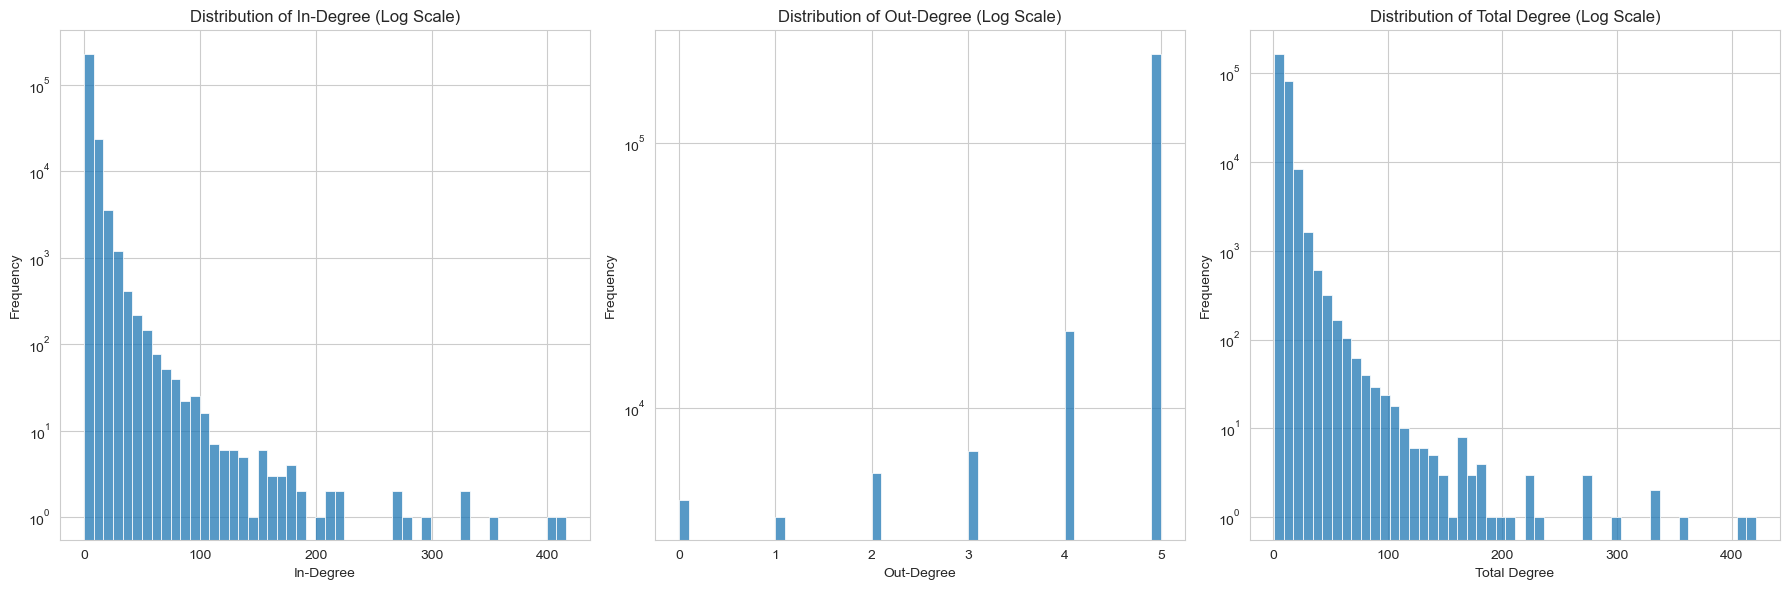

In [ ]:
in_degree_counts = pd.Series([degree for node, degree in G.in_degree()])
out_degree_counts = pd.Series([degree for node, degree in G.out_degree()])
degree_counts = pd.Series([degree for node, degree in G.degree()])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(in_degree_counts, bins=50, log=True, ax=axes[0])
axes[0].set_title('Distribution of In-Degree (Log Scale)')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Frequency')

sns.histplot(out_degree_counts, bins=50, log=True, ax=axes[1])
axes[1].set_title('Distribution of Out-Degree (Log Scale)')
axes[1].set_xlabel('Out-Degree')
axes[1].set_ylabel('Frequency')

sns.histplot(degree_counts, bins=50, log=True, ax=axes[2])
axes[2].set_title('Distribution of Total Degree (Log Scale)')
axes[2].set_xlabel('Total Degree')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Common Neighbors, Jaccard, dan Adamic-Adar menunjukkan hasil yang hampir identik karena ketiganya mengandalkan jumlah neighbor bersama untuk menentukan kemungkinan adanya edge. Seperti yang terlihat pada histogram degree, sebagian besar node memiliki degree rendah, sementara sedikit node memiliki degree sangat tinggi. Hal ini menyebabkan banyak prediksi yang benar berasal dari pasangan node yang memang memiliki neighbor bersama, sehingga metode berbasis neighbor overlap bekerja dengan sangat baik. Akurasi tinggi pada Precision@200K (0.9998) dan MAP (~0.9999) menunjukkan bahwa metode ini sangat mampu mengidentifikasi edge yang benar dengan tingkat kepastian yang tinggi.

Sebaliknya, Preferential Attachment memiliki performa jauh lebih buruk karena hanya mengandalkan perkalian degree tanpa mempertimbangkan neighbor overlap. Pada graf ini, high-degree nodes sering tidak langsung terhubung, melainkan memiliki banyak neighbor yang berbeda, sehingga metode ini sering memberikan skor tinggi pada pasangan node yang sebenarnya tidak memiliki edge. Ini menjelaskan mengapa AUC-ROC dan Recall jauh lebih rendah dibanding metode lain. Oleh karena itu, dalam graf seperti ini, metode berbasis neighbor overlap lebih unggul, sementara metode berbasis degree seperti Preferential Attachment kurang efektif dalam menangkap hubungan yang sebenarnya.

## Basic ML Link Prediction

### Feature Selection

In [20]:
def extract_features(G, edge_list):
    features = []

    for u, v in edge_list:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        jaccard = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        pref_attach = list(nx.preferential_attachment(G, [(u, v)]))[0][2]

        node_features = ['salesrank', 'review_cnt', 'downloads', 'rating', 
                         'in_degree', 'out_degree', 'pagerank_centrality', 
                         'betweenness_centrality', 'harmonic_closeness_centrality', 
                         'degree_centrality', 'community']

        node_u_features = [G.nodes[u].get(feat, 0) for feat in node_features]
        node_v_features = [G.nodes[v].get(feat, 0) for feat in node_features]

        features.append([u, v, common_neighbors, jaccard, pref_attach] + node_u_features + node_v_features)

    columns = ["node1", "node2", "common_neighbors", "jaccard", "preferential_attachment"] 
    columns += [f"{feat}_u" for feat in node_features]
    columns += [f"{feat}_v" for feat in node_features]

    return pd.DataFrame(features, columns=columns)

def feature_selection(X_train, y_train, top_k=10):
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

    feature_ranking = np.argsort(mi_scores)[::-1]

    selected_features = feature_ranking[:top_k]
    X_train_selected = X_train.iloc[:, selected_features]

    return X_train_selected, selected_features


### Train and Evaluation

In [30]:
train_pairs = train_edges + train_non_edges
train_labels = np.array([1] * len(train_edges) + [0] * len(train_non_edges))

test_pairs = test_edges + test_non_edges
test_labels = np.array([1] * len(test_edges) + [0] * len(test_non_edges))

train_features = extract_features(G_train, train_pairs)
test_features = extract_features(G_train, test_pairs)

X_train = train_features.drop(columns=["node1", "node2"])
X_test = test_features.drop(columns=["node1", "node2"])

# X_train_selected, selected_features = feature_selection(X_train, train_labels, top_k=10)
# selected_feature_names = X_train.columns[selected_features]
# print("Fitur yang dipilih:", selected_feature_names.tolist())

# X_test_selected = X_test.iloc[:, selected_features]

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

k = 100000

print("{:<25} {:>10} {:>10} {:>15} {:>15} {:>10} {:>10}".format(
    "Model", "AUC-ROC", "AP Score", f"Precision@{k}", f"Recall@{k}", "MAP", f"F1@{k}"
))
print("=" * 105)

for name, model in models.items():
    model.fit(X_train, train_labels)
    
    probabilities = model.predict_proba(X_test)[:, 1]
    
    auc_roc = roc_auc_score(test_labels, probabilities)
    ap_score = average_precision_score(test_labels, probabilities)
    
    precision_at_k_ml = precision_at_k(test_labels, probabilities, k)
    recall_at_k_ml = recall_at_k(test_labels, probabilities, k)
    map_score = mean_average_precision(test_labels, probabilities)
    f1_k_ml = f1_beta_at_k(test_labels, probabilities, k)

    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        name.upper(), auc_roc, ap_score, precision_at_k_ml, recall_at_k_ml, map_score, f1_k_ml
    ))


Model                        AUC-ROC   AP Score Precision@100000   Recall@100000        MAP  F1@100000
RANDOM FOREST               0.913669   0.941762        0.999900        0.414092   0.942984   0.585648
LOGISTIC REGRESSION         0.896471   0.934223        0.999940        0.414109   0.935463   0.585671
NAIVE BAYES                 0.918207   0.942835        0.999350        0.413864   0.945220   0.585326


Model machine learning menunjukkan performa yang cukup baik dalam prediksi hubungan di graf, dengan AUC-ROC di atas 0.89 untuk semua model. Naïve Bayes memiliki AUC-ROC tertinggi (0.918), sementara Random Forest unggul dalam AP Score (0.942) dan MAP (0.942). Precision@100000 mendekati 1 untuk semua model, tetapi recall masih sekitar 41.4%, menunjukkan bahwa meskipun model dapat mengidentifikasi pasangan yang benar dengan tingkat presisi tinggi, masih ada banyak pasangan yang terlewat. F1@100000 di kisaran 0.585 mengindikasikan keseimbangan antara precision dan recall masih dapat ditingkatkan, meskipun secara keseluruhan, model ML sudah cukup efektif dalam memprediksi keterhubungan antar node.

Jika dibandingkan dengan metode heuristic, model ML memiliki keunggulan dalam AUC-ROC dan AP Score, yang mencerminkan kemampuan yang lebih baik dalam membedakan pasangan yang benar dan salah. Namun, metode heuristic seperti Common Neighbors dan Adamic-Adar memberikan hasil Precision@100000, Recall@100000, dan MAP yang hampir identik dengan Logistic Regression, bahkan sedikit lebih tinggi dalam MAP. Preferential Attachment menjadi satu-satunya heuristic dengan performa jauh lebih rendah, terutama dalam AUC-ROC (0.597) dan F1@100000 (0.387), yang menunjukkan keterbatasannya dalam menangkap pola hubungan di dataset ini. Secara keseluruhan, meskipun metode heuristic dapat menjadi alternatif yang lebih sederhana, model ML tetap memberikan fleksibilitas lebih tinggi dengan hasil yang lebih baik dalam evaluasi berbasis probabilitas.

## Graph Embedding Link Prediction 

## Graph Neural Network (GNN) Link Prediction